# Solution Method

Define the random variable $X_n$ as the number of pairs that have been flipped over by Kate's son at step $n$. In particular the support of $X_n$ is the set $\{0, 1, \ldots, 10\}$ and by construction we have an infinite sequence of random variables $X_1, X_2, \ldots$. Moreover, from the problem statement we observe that our stochastic process can be modeled as a Markov chain which has the following transition probabilities for $i \in \{0, 1, \ldots, 9\}$

$$
\mathbb{P}(X_n = i \mid X_{n-1} = i) = \frac{18-2i}{19-2i}
$$

and

$$
\mathbb{P}(X_n = i+1 \mid X_{n-1} = i) = \frac{1}{19-2i}.
$$

We observe that $i = 10$ is a recurrent state since the game is over and thus we have

$$
\mathbb{P}(X_n = 10 \mid X_{n-1} = 10) = 1.
$$

Visually this gives us a Markov transition graph that looks like

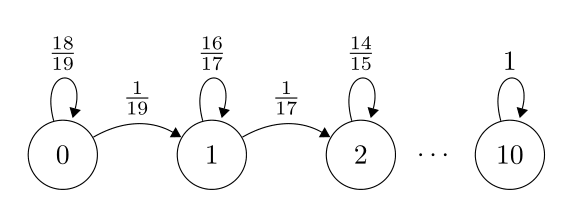

From this definition we observe that the set of transients states is $\{0, 1, \ldots, 9\}$ and $\{10\}$ is the recurrent state in the Markov chain. As an intuitive justification for the transition probabilities for the transient states, suppose that $X_n = 0$. By the problem statement we know that Kate's son selects pairs at random, and thus we can decompose this process into two stages. First, Kate's son selects any of the $20$ cards at random. Next, since her son has no ability to match them, he similarly will select one of the remaining $19$ cards randomly. We know for $X_n = 0$ that only one out of the $19$ possible cards her son can pick will match the first card selected. Thus there is $1/19$ chance her son will transition from zero to one pairs selected. A similar argument can be made for $i = 1, 2, \ldots, 9$.

Using these definitions, we now want to compute the expected number of steps until we are absorbed into state ten given that we started in $X_0 = 0$. Using the equations for [absorbing Markov chains](https://en.wikipedia.org/wiki/Absorbing_Markov_chain) provided by Wikipeida this problem can be solved by first computing 

$$
\mathbf{N} = (\mathbf{I}_t - \mathbf{Q})^{-1}
$$

where $\mathbf{I}_t$ is a $t \times t$ identity matrix with $t$ equalling the cardinality of the set of transient states and $\mathbf{Q}$ as the transition probability matrix between transient states. Using $\mathbf{N}$ we can then solve for the expected steps to absorption by computing

$$
\mathbf{t} = \mathbf{N}\mathbf{1}
$$

where $\mathbf{1}$ is a $t \times 1$ vector consisting of ones. In particular we care about $\mathbf{t}_0$ as this is the expected number of steps to absorption from the beginning state of no pairs being matched.

Finally, since we have to account for the time component of Kate's son flipping over cards, we observe from the problem statement that any particular step takes a total of two seconds -- one second to flip over a pair of cards and another to determine if a pair has been created. Therefore the expected time Kate's daughter will wait until it is her turn to play equals

$$
\mathbb{E}[\text{Time until it's Kate's daughter's turn}] = 2\mathbf{t}_0.
$$

While the above problem is solvable by hand, it involves inverting a $10 \times 10$ matrix which is a bit much for my taste. Thus I performed the matrix computations below. In the end we get

$$
\mathbf{t}_0 = 100
$$ 

which gives us

$$
\mathbb{E}[\text{Time until it's Kate's daughter's turn}] = 200 \text{ seconds}.
$$

## Extra Information

In addition to computing the expected time until it's Kate's daughter's turn, we might also be reasonably interested in knowing the variance on this time. Using the equations provided by Wikipeida this quantity is

$$
(2\mathbf{N} - \mathbf{I}_t)\mathbf{t} - \mathbf{t}_{sq}
$$

where $\mathbf{t}_{sq}$ is the Hardamand product of the expected absorption time. Computing this we get 

$$
Var(\text{Number of steps until game ends}) = 1230.
$$

From this we conclude that while the expected time until it's Kate's daughter's turn is relatively short, the finish time also has high variance, so her daughter could be waiting a while.

In [1]:
import numpy as np


class MarkovChain(object):
    """Defines the Markov chain model used to compute the expected and the
    variance of the step until reaching the absorbing state

    Parameters
    ----------
    n_state = int
        The cardinality of the set of transient states

    Attributes
    ----------
    exp_absorb: array, shape=(n_state, 1)
        Vector containing the expected steps until absorption

    var_absorb: array, shape=(n_state, 1)
        Vector containing the variance on the number of steps until
        absorption

    """

    def __init__(self, n_state):
        self.n_state = n_state

        # Instantiate our vectors and matrices we will need later
        self.exp_absorb = np.empty(shape=(self.n_state, 1), dtype=int)
        self.var_absorb = np.empty(shape=(self.n_state, 1), dtype=int)
        self.q_mat = np.zeros(shape=(self.n_state, self.n_state), dtype=float)
        self.n_mat = np.empty(shape=(self.n_state, self.n_state), dtype=float)

    def build_q_matrix(self):
        """Builds the Q transition probability matrix

        Returns
        -------
        object: self

        """
        # Populate the Q matrix according to the proscribed Markov chain
        for i in range(self.n_state):
            self.q_mat[i, i] = (18 - 2*i)/(19 - 2*i)
            if i == (self.n_state - 1):
                break
            else:
                self.q_mat[i, i+1] = 1/(19 - 2*i)
        return self

    def compute_n_matrix(self):
        """Computes the N matrix

        Returns
        -------
        object: self

        """
        self.n_mat = np.linalg.inv((np.eye(self.n_state) - self.q_mat))
        return self

    def compute_exp_absorb(self):
        """Computes the expected time to absorption

        Returns
        -------
        object: self

        """
        one_vect = np.ones(shape=(self.n_state, 1))
        self.exp_absorb = np.matmul(self.n_mat, one_vect)
        return self

    def compute_var_absorb(self):
        """Computes the variance on the number of steps to absorption

        Returns
        -------
        object: self

        """
        lhs = np.matmul((2*self.n_mat - np.eye(self.n_state)), self.exp_absorb)
        hardamand_exp = np.square(self.exp_absorb)
        self.var_absorb = lhs - hardamand_exp
        return self

    def run(self):
        """Runs all methods in the MarkovChain object and allows us to access
        the expected time and variance of the time until absorption

        Returns
        -------
        object: self

        """
        self.build_q_matrix()
        self.compute_n_matrix()
        self.compute_exp_absorb()
        self.compute_var_absorb()
        return self

In [2]:
# Define the MarkovChain object and run all the methods to get the
# information we want
mc = MarkovChain(n_state=10)
mc.run()
print('Expected number of steps to absorption: {}'.format(mc.exp_absorb[0]))
print('Variance on number of steps to absorption: {}'.format(mc.var_absorb[0]))

Expected number of steps to absorption: [100.]
Variance on number of steps to absorption: [ 1230.]
